# 3D Face Plot

Attenzione visualization

In [88]:
%load_ext autoreload
%autoreload 2
import os
from os.path import join
import sys
import time
from random import randint
import random

import cv2 as cv
import numpy as np
import imutils
import matplotlib.animation
%matplotlib notebook
from glob import glob
from matplotlib import cbook
from matplotlib import cm
#from matplotlib.colors import LightSource
import face_alignment
import numpy as np

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from matplotlib import animation

from skimage import io
from tqdm import tqdm_notebook as tqdm
from IPython.display import clear_output
from pathlib import Path

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [89]:
# Generate random hex colors
def rhex():
  r = lambda: random.randint(0,255)
  return '#%02X%02X%02X' % (r(), r(), r())

In [90]:
# init 3d face
# Run the 3D face alignment on a test image, without CUDA.
fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._3D, device='cuda:0', flip_input=True)

In [276]:
fp_im = '/data_store_hdd/datasets/people/vgg_face2/media/original/test/n000009/0012_01.jpg'
im = cv.imread(fp_im)
plt.imshow(im)

In [288]:
def generate_3d_face_plain(im, lm):
  preds = lm
  fig = plt.figure(figsize=plt.figaspect(.5))
  ax = fig.add_subplot(1, 2, 1)
  ax.imshow(im)
  ax.plot(preds[0:17,0],preds[0:17,1],marker='o',markersize=6,linestyle='-',color='w',lw=2)
  ax.plot(preds[17:22,0],preds[17:22,1],marker='o',markersize=6,linestyle='-',color='w',lw=2)
  ax.plot(preds[22:27,0],preds[22:27,1],marker='o',markersize=6,linestyle='-',color='w',lw=2)
  ax.plot(preds[27:31,0],preds[27:31,1],marker='o',markersize=6,linestyle='-',color='w',lw=2)
  ax.plot(preds[31:36,0],preds[31:36,1],marker='o',markersize=6,linestyle='-',color='w',lw=2)
  ax.plot(preds[36:42,0],preds[36:42,1],marker='o',markersize=6,linestyle='-',color='w',lw=2)
  ax.plot(preds[42:48,0],preds[42:48,1],marker='o',markersize=6,linestyle='-',color='w',lw=2)
  ax.plot(preds[48:60,0],preds[48:60,1],marker='o',markersize=6,linestyle='-',color='w',lw=2)
  ax.plot(preds[60:68,0],preds[60:68,1],marker='o',markersize=6,linestyle='-',color='w',lw=2) 
  ax.axis('off')

  ax = fig.add_subplot(1, 2, 2, projection='3d')
  surf = ax.scatter(preds[:,0]*1.2,preds[:,1],preds[:,2],c="cyan", alpha=1.0, edgecolor='b')
  ax.plot3D(preds[:17,0]*1.2,preds[:17,1], preds[:17,2], color='blue' )
  ax.plot3D(preds[17:22,0]*1.2,preds[17:22,1],preds[17:22,2], color='blue')
  ax.plot3D(preds[22:27,0]*1.2,preds[22:27,1],preds[22:27,2], color='blue')
  ax.plot3D(preds[27:31,0]*1.2,preds[27:31,1],preds[27:31,2], color='blue')
  ax.plot3D(preds[31:36,0]*1.2,preds[31:36,1],preds[31:36,2], color='blue')
  ax.plot3D(preds[36:42,0]*1.2,preds[36:42,1],preds[36:42,2], color='blue')
  ax.plot3D(preds[42:48,0]*1.2,preds[42:48,1],preds[42:48,2], color='blue')
  ax.plot3D(preds[48:,0]*1.2,preds[48:,1],preds[48:,2], color='blue' )
  
  # pad
  xmm = (np.min(lm[:,0]),np.max(lm[:,0]))
  ymm = (np.min(lm[:,1]),np.max(lm[:,1]))
  zmm = (np.min(lm[:,2]),np.max(lm[:,2]))
  
  print(xmm, ymm, zmm)
#   ax.set_xticks([])
#   ax.set_yticks([])
#   ax.set_zticks([])
  plt.setp( ax.get_xticklabels(), visible=False)
  plt.setp( ax.get_yticklabels(), visible=False)
  #ax.set_xlim(xmm[0]-50, xmm[1]+50)
  #ax.set_ylim(ymm[0]-50, ymm[1]+50)
  #ax.set_ylim(zmm[0]- .1*zmm[0],zmm[1] + .1*zmm[1])
  #ax.set_ylim(103, 275)
  #ax.set_zlim((-100,100))
  ax.view_init(elev=15., azim=135.)

  plt.show()

<IPython.core.display.Javascript object>


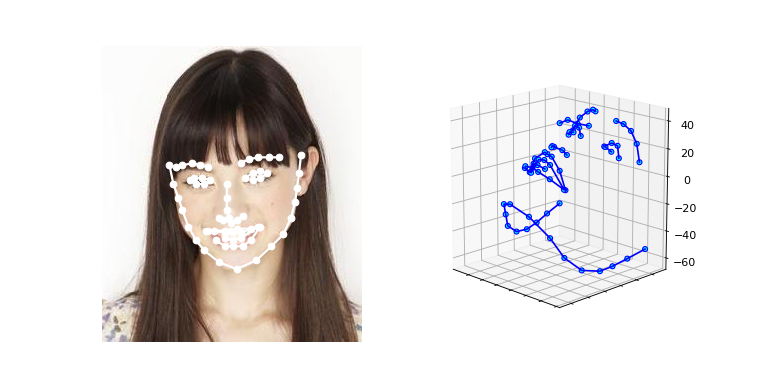

(68.0, 201.0) (110.0, 225.0) (-61.021374, 41.419292)


In [367]:
im = cv.imread(fp_im)
im_rgb = cv.cvtColor(im, cv.COLOR_BGR2RGB)
lm = fa.get_landmarks(im_rgb)[-1]
generate_3d_face_plain(im_rgb, lm)

In [393]:
 # line weight
def generate_3d_face(lm, fp_out, num_frames=30, dpi=72, stroke_weight=2, size=(480,480),
  mark_size=10, mark_type='.', mark_clr=(0,255,0), fps=10, transparent=False):
  '''Generates 3D plot of face landmarks
  '''
  # convert opencv BGR numpy image to RGB
  bg_color = '#%02x%02x%02x' % (0,0,0)
  mark_clr = '#%02x%02x%02x' % (0,255,255)
  
  # scale to make larger
  #lm = np.array([1.2*x,y,z] for x,y,z in list(lm))
  
  # center x,y,z
  xmm = (np.min(lm[:,0]),np.max(lm[:,0]))
  ymm = (np.min(lm[:,1]),np.max(lm[:,1]))
  zmm = (np.min(lm[:,2]),np.max(lm[:,2]))
  
  # make copy of landmarks
  lm_orig = lm.copy()
  xmm = (np.min(lm_orig[:,0]),np.max(lm_orig[:,0]))
  ymm = (np.min(lm_orig[:,1]),np.max(lm_orig[:,1]))
  zmm = (np.min(lm_orig[:,2]),np.max(lm_orig[:,2]))
  
  # swap the y and z components to improve 3d rotation angles for matplotlib
  lm = np.zeros_like(lm_orig).astype(np.uint8)
  for i,p in enumerate(lm_orig):
    x,y,z = p
    lm[i] = np.array([x - xmm[0], z - zmm[0], y - ymm[0]])
  
  # Create plot
  figsize = (size[0]/dpi, size[1]/dpi )
  fig = plt.figure(figsize=figsize, dpi=dpi)  # frameon=False
  #fig.set_size_inches(100/100, 1, forward=False)
  fig.tight_layout()
  fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
  ax = fig.add_subplot(111, projection='3d')
  ax.set_facecolor(bg_color) # background color
  
  xscale, yscale, zscale = (1.2, 1.0, 1.0)
  
  # scatter plot the dots
  # jaw line
  mark_clr = '#%02x%02x%02x' % (0,255,0)  # green
  ax.plot3D(lm[:17,0]*1.2,lm[:17,1], lm[:17,2],
            marker=mark_type, markersize=mark_size, color=mark_clr,linewidth=stroke_weight)
  # stage-right eyebrow
  mark_clr = '#%02x%02x%02x' % (255,0,0)  # green
  ax.plot3D(lm[17:22,0]*1.2,lm[17:22,1],lm[17:22,2],
            marker=mark_type, markersize=mark_size, color=mark_clr,linewidth=stroke_weight)
  # stage-left eyebrow
  mark_clr = '#%02x%02x%02x' % (255,255,0)  # yellow
  ax.plot3D(lm[22:27,0]*1.2,lm[22:27,1],lm[22:27,2], 
            marker=mark_type, markersize=mark_size, color=mark_clr,linewidth=stroke_weight)
  # nose ridge
  mark_clr = '#%02x%02x%02x' % (0,0,255)  # blue
  ax.plot3D(lm[27:31,0]*1.2,lm[27:31,1],lm[27:31,2],
            marker=mark_type, markersize=mark_size, color=mark_clr,linewidth=stroke_weight)
  # nose-bottom
  mark_clr = '#%02x%02x%02x' % (255,0,255)  # magenta
  ax.plot3D(lm[31:36,0]*1.2,lm[31:36,1],lm[31:36,2],
            marker=mark_type, markersize=mark_size, color=mark_clr,linewidth=stroke_weight)
  # stage-left eye
  mark_clr = '#%02x%02x%02x' % (0,255,255)  # cyan
  px, py, pz = lm[36:42,0]*1.2,lm[36:42,1],lm[36:42,2]
  px = np.append(px, lm[36,0]*1.2)
  py = np.append(py, lm[36,1])
  pz = np.append(pz, lm[36,2])
  ax.plot3D(px, py, pz, marker=mark_type, markersize=mark_size, color=mark_clr,linewidth=stroke_weight)
  
  # stage-right eye
  mark_clr = '#%02x%02x%02x' % (255,255,255)  # white
  px, py, pz = lm[42:48,0]*1.2,lm[42:48,1],lm[42:48,2]
  px = np.append(px, lm[42,0]*1.2)
  py = np.append(py, lm[42,1])
  pz = np.append(pz, lm[42,2])
  ax.plot3D(px, py, pz, marker=mark_type, markersize=mark_size, color=mark_clr,linewidth=stroke_weight)
  
  # mouth
  mark_clr = '#%02x%02x%02x' % (255,125,0)  # orange?
  px, py, pz = lm[48:,0]*1.2,lm[48:,1],lm[48:,2]
  px = np.append(px, lm[48,0]*1.2)
  py = np.append(py, lm[48,1])
  pz = np.append(pz, lm[48,2])
  ax.plot3D(px, py, pz, marker=mark_type, markersize=mark_size, color=mark_clr, linewidth=stroke_weight)
  
  rh = '#00ff00'  # edge color
  #ax.scatter(lm[:,0]*xscale,lm[:,1]*yscale,lm[:,2]*zscale, c=rh, alpha=1.0, s=35, edgecolor=rh)
  #ax.scatter(lm[:,0]*xscale,lm[:,1]*yscale,lm[:,2]*zscale, c=rh, alpha=1.0, s=1)
  
  # center center x,y,z points
  cx = ((xmm[0] - xmm[1]) // 2) + xmm[1]
  cy = ((ymm[1] - ymm[0]) // 2) + ymm[0]
  cz = ((zmm[1] - zmm[0]) // 2) + zmm[0]
  
  # set initial plot view
  ax.view_init(elev=120., azim=70.)
  
  # remove ticks
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_zticks([])
    
  # remove axis
  ax.set_frame_on(False)
  ax.set_axis_off()

  # rotation increments: from 0 to 360 in num_frames
  phi = np.linspace(0, 2*np.pi, num_frames)

  def update(phi):
    ax.view_init(180,phi*180./np.pi)
  
  ani = matplotlib.animation.FuncAnimation(fig, update, frames=phi)
  savefig_kwargs = {'pad_inches': 0, 'transparent': transparent}
  ani.save(fp_out, writer='imagemagick', fps=fps, savefig_kwargs=savefig_kwargs)
  clear_output()

In [394]:
# filepaths
dir_out = '/home/adam/Downloads/'
fp_out = join(dir_out, '{}.gif'.format(Path(fp_im).stem))

# generate 3D face
st = time.time()
generate_3d_face(lm,fp_out, num_frames=20, fps=10)
print('time: {:.4f}'.format((time.time()-st)/1000))
print(f'Saved file to {fp_out}')

time: 0.0017
Saved file to /home/adam/Downloads/0012_01.gif
